In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Set plot style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

### Load Results

In [2]:
# Define paths to results
results_dir = Path("deepar_results")
backtest_path = results_dir / "test_backtest_results.csv"
portfolio_path = results_dir / "test_portfolio_backtest_results.csv"

# Load backtest results
if backtest_path.exists():
    backtest_df = pd.read_csv(backtest_path)
    # Convert date columns to datetime
    backtest_df['date'] = pd.to_datetime(backtest_df['date'])
    backtest_df['next_date'] = pd.to_datetime(backtest_df['next_date'])
    print(f"Loaded backtest results with {len(backtest_df)} rows")
else:
    print(f"Backtest results file not found: {backtest_path}")
    
# Load portfolio results
if portfolio_path.exists():
    portfolio_df = pd.read_csv(portfolio_path)
    # Convert date columns to datetime
    portfolio_df['date'] = pd.to_datetime(portfolio_df['date'])
    print(f"Loaded portfolio results with {len(portfolio_df)} rows")
else:
    print(f"Portfolio results file not found: {portfolio_path}")

Loaded backtest results with 29484 rows
Loaded portfolio results with 364 rows


### Results Data Exploration
#### Overview of Backtest Results

In [3]:
# Display basic information about the backtest results
print("Backtest Results Overview:")
print(f"Date Range: {backtest_df['date'].min()} to {backtest_df['date'].max()}")
print(f"Number of tickers: {backtest_df['ticker'].nunique()}")
print(f"Total predictions: {len(backtest_df)}")

# Display first few rows of the backtest data
print("\nSample of backtest data:")
backtest_df.head()

Backtest Results Overview:
Date Range: 2024-02-26 00:00:00 to 2025-02-23 00:00:00
Number of tickers: 81
Total predictions: 29484

Sample of backtest data:


,date,next_date,ticker,actual_return,predicted_mean,predicted_median,var_10,var_5,var_1,mse,mae,hit_10,hit_5,hit_1
0,2024-02-26,2024-02-27,AAPL,1.008114,1.006214,1.006445,0.988527,0.981996,0.961979,0.000004,0.001900,False,False,False
1,2024-02-26,2024-02-27,ABT,1.005982,1.002681,1.003397,0.982308,0.972469,0.940052,0.000011,0.003301,False,False,False
2,2024-02-26,2024-02-27,ADBE,0.985744,0.998141,0.998892,0.980505,0.971507,0.935097,0.000154,0.012397,False,False,False
3,2024-02-26,2024-02-27,AIG,1.008833,0.997828,0.997204,0.980974,0.972510,0.935730,0.000121,0.011006,False,False,False
4,2024-02-26,2024-02-27,ALL,0.998373,0.990347,0.989871,0.972570,0.965634,0.952235,0.000064,0.008026,False,False,False


#### Distribution of Results


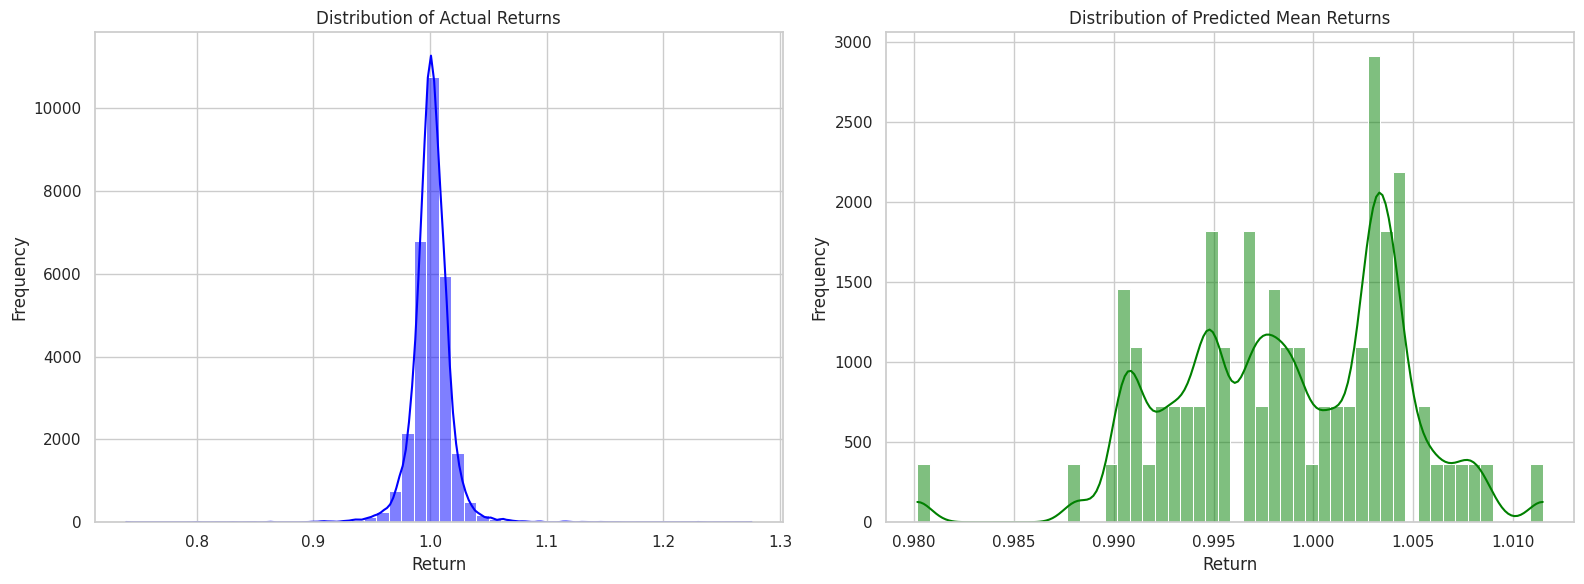

,Actual Returns,Predicted Returns
count,29484.000000,29484.000000
mean,1.000848,0.998747
std,0.017010,0.005620
min,0.739415,0.980181
25%,0.993297,0.994692
50%,1.000987,0.998922
75%,1.008881,1.003306
max,1.275488,1.011472


In [4]:
# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot distribution of actual returns
sns.histplot(backtest_df['actual_return'], kde=True, ax=ax1, color='blue', bins=50)
ax1.set_title('Distribution of Actual Returns')
ax1.set_xlabel('Return')
ax1.set_ylabel('Frequency')

# Plot distribution of predicted returns
sns.histplot(backtest_df['predicted_mean'], kde=True, ax=ax2, color='green', bins=50)
ax2.set_title('Distribution of Predicted Mean Returns')
ax2.set_xlabel('Return')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate summary statistics for actual and predicted returns
return_stats = pd.DataFrame({
    'Actual Returns': backtest_df['actual_return'].describe(),
    'Predicted Returns': backtest_df['predicted_mean'].describe()
})
return_stats

### Evaluation of Mean Return Value
#### Time Series of Portfolio Returns

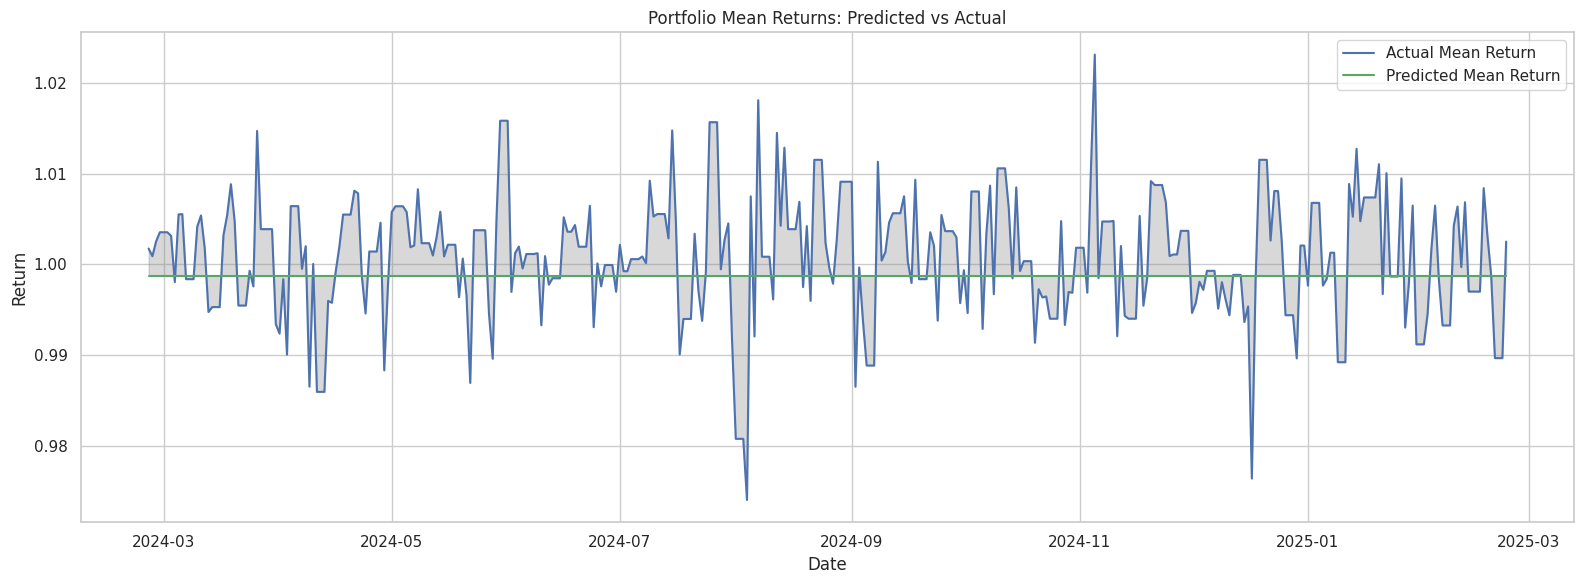

In [5]:
# Plot the time series of portfolio returns
plt.figure(figsize=(16, 6))
plt.plot(portfolio_df['date'], portfolio_df['actual_return'], 'b-', label='Actual Mean Return')
plt.plot(portfolio_df['date'], portfolio_df['predicted_mean'], 'g-', label='Predicted Mean Return')
plt.fill_between(portfolio_df['date'], 
                 portfolio_df['predicted_mean'], 
                 portfolio_df['actual_return'], 
                 color='gray', alpha=0.3)
plt.title('Portfolio Mean Returns: Predicted vs Actual')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#### Ticker-Level Return Prediction Performance


In [6]:
# Calculate evaluation metrics per ticker
ticker_metrics = backtest_df.groupby('ticker').agg({
    'mse': 'mean',
    'mae': 'mean',
    'actual_return': ['mean', 'std'],
    'predicted_mean': ['mean', 'std'],
})

# Flatten the MultiIndex columns
ticker_metrics.columns = ['_'.join(col).strip() for col in ticker_metrics.columns.values]

# Calculate correlation between actual and predicted returns per ticker
ticker_corr = []
for ticker in backtest_df['ticker'].unique():
    ticker_data = backtest_df[backtest_df['ticker'] == ticker]
    corr = ticker_data[['actual_return', 'predicted_mean']].corr().iloc[0, 1]
    ticker_corr.append({'ticker': ticker, 'correlation': corr})

ticker_corr_df = pd.DataFrame(ticker_corr)
ticker_corr_df = ticker_corr_df.set_index('ticker')

# Join the correlation with ticker metrics
ticker_metrics = ticker_metrics.join(ticker_corr_df)

# Add normalized MSE (NMSE) relative to the variance of actual returns
ticker_metrics['nmse'] = ticker_metrics['mse_mean'] / (ticker_metrics['actual_return_std'] ** 2)

# Sort by MSE
ticker_metrics = ticker_metrics.sort_values('mse_mean')

# Display the top 10 tickers with lowest MSE
print("Top 10 tickers with lowest Mean Squared Error:")
display(ticker_metrics.head(10))

# Display the worst 10 tickers with highest MSE
print("\nBottom 10 tickers with highest Mean Squared Error:")
display(ticker_metrics.tail(10))



Top 10 tickers with lowest Mean Squared Error:


,mse_mean,mae_mean,actual_return_mean,actual_return_std,predicted_mean_mean,predicted_mean_std,correlation,nmse
ticker,,,,,,,,
LIN,0.000087,0.007149,1.000381,0.008832,0.997377,0.0,NaN,1.112925
DUK,0.000106,0.007993,1.001430,0.010324,1.001691,0.0,NaN,0.997887
JNJ,0.000107,0.007805,1.000382,0.009600,1.004206,0.0,NaN,1.155992
MO,0.000114,0.007829,1.002060,0.010622,1.003462,0.0,NaN,1.014666
CSCO,0.000121,0.007945,1.001453,0.010864,1.003336,0.0,NaN,1.027290
SO,0.000123,0.008506,1.001314,0.010969,1.002929,0.0,NaN,1.018933
HON,0.000126,0.008128,1.000383,0.011060,0.998485,0.0,NaN,1.026713
CL,0.000129,0.007989,1.000559,0.011297,1.001679,0.0,NaN,1.007085
MCD,0.000132,0.008388,1.000458,0.011309,1.002450,0.0,NaN,1.028300



Bottom 10 tickers with highest Mean Squared Error:


,mse_mean,mae_mean,actual_return_mean,actual_return_std,predicted_mean_mean,predicted_mean_std,correlation,nmse
ticker,,,,,,,,
TGT,0.000572,0.016326,1.000350,0.021639,0.990082,0.0,NaN,1.222379
QCOM,0.000573,0.018241,1.000604,0.022576,0.992532,0.0,NaN,1.125077
CVS,0.000603,0.016291,1.000840,0.023830,1.006925,0.0,NaN,1.062452
NKE,0.000640,0.013427,0.998291,0.024756,1.003650,0.0,NaN,1.044103
ADBE,0.000675,0.014990,0.998423,0.026015,0.998141,0.0,NaN,0.997370
MMM,0.000684,0.013501,1.003569,0.024573,0.994518,0.0,NaN,1.132918
UNH,0.000714,0.023024,0.999937,0.018019,0.980181,0.0,NaN,2.199255
NVDA,0.001078,0.025130,1.001621,0.032854,1.002815,0.0,NaN,0.998572
INTC,0.001670,0.025912,0.998211,0.039806,1.007707,0.0,NaN,1.054158


### Value at Risk (VaR) Evaluation
#### VaR Hit Ratios by Confidence Level

Top 10 tickers with most accurate VaR estimates:


,VaR_90%_Hit_Ratio,VaR_95%_Hit_Ratio,VaR_99%_Hit_Ratio,VaR_90%_Error,VaR_95%_Error,VaR_99%_Error,Average_Error
ticker,,,,,,,
COF,0.098901,0.041209,0.008242,0.001099,0.008791,0.001758,0.003883
QCOM,0.107143,0.041209,0.010989,0.007143,0.008791,0.000989,0.005641
MRK,0.098901,0.035714,0.013736,0.001099,0.014286,0.003736,0.006374
UPS,0.112637,0.054945,0.008242,0.012637,0.004945,0.001758,0.006447
C,0.115385,0.052198,0.008242,0.015385,0.002198,0.001758,0.006447
BKNG,0.107143,0.063187,0.010989,0.007143,0.013187,0.000989,0.007106
NEE,0.118132,0.049451,0.005495,0.018132,0.000549,0.004505,0.007729
AMT,0.085165,0.046703,0.002747,0.014835,0.003297,0.007253,0.008462
CVX,0.123626,0.054945,0.010989,0.023626,0.004945,0.000989,0.009853



Overall VaR Hit Ratios (All Tickers):


,Theoretical,Empirical
90% VaR,0.10,0.081298
95% VaR,0.05,0.039649
99% VaR,0.01,0.007428


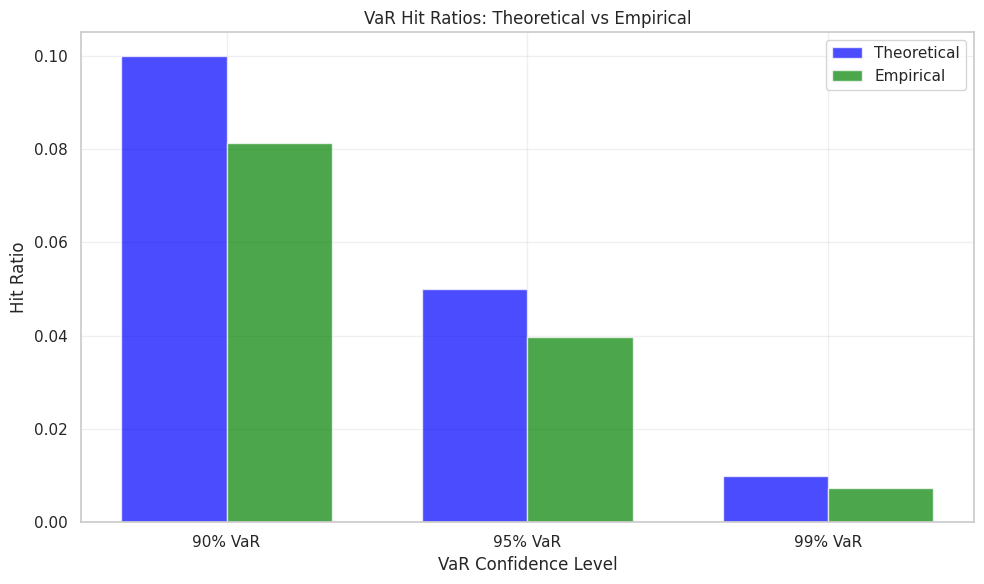

In [7]:
# Calculate hit ratios for different VaR confidence levels
var_hit_ratios = backtest_df.groupby('ticker').agg({
    'hit_10': 'mean',  # 10% VaR (90% confidence)
    'hit_5': 'mean',   # 5% VaR (95% confidence)
    'hit_1': 'mean'    # 1% VaR (99% confidence)
})

# Rename columns for clarity
var_hit_ratios.columns = ['VaR_90%_Hit_Ratio', 'VaR_95%_Hit_Ratio', 'VaR_99%_Hit_Ratio']

# Calculate the absolute error from theoretical hit rates
var_hit_ratios['VaR_90%_Error'] = np.abs(var_hit_ratios['VaR_90%_Hit_Ratio'] - 0.10) 
var_hit_ratios['VaR_95%_Error'] = np.abs(var_hit_ratios['VaR_95%_Hit_Ratio'] - 0.05)
var_hit_ratios['VaR_99%_Error'] = np.abs(var_hit_ratios['VaR_99%_Hit_Ratio'] - 0.01)

# Sort by average error across all VaR levels
var_hit_ratios['Average_Error'] = (var_hit_ratios['VaR_90%_Error'] + 
                                   var_hit_ratios['VaR_95%_Error'] + 
                                   var_hit_ratios['VaR_99%_Error']) / 3
var_hit_ratios = var_hit_ratios.sort_values('Average_Error')

# Display the top 10 tickers with most accurate VaR estimates
print("Top 10 tickers with most accurate VaR estimates:")
display(var_hit_ratios.head(10))

# Calculate overall hit ratios
overall_hit_ratios = {
    'VaR_90%': backtest_df['hit_10'].mean(),
    'VaR_95%': backtest_df['hit_5'].mean(),
    'VaR_99%': backtest_df['hit_1'].mean()
}

# Create a DataFrame for the overall hit ratios
overall_hit_df = pd.DataFrame({
    'Theoretical': [0.10, 0.05, 0.01],
    'Empirical': [overall_hit_ratios['VaR_90%'], overall_hit_ratios['VaR_95%'], overall_hit_ratios['VaR_99%']]
}, index=['90% VaR', '95% VaR', '99% VaR'])

# Display the overall hit ratios
print("\nOverall VaR Hit Ratios (All Tickers):")
display(overall_hit_df)

# Plot the overall hit ratios
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(3)

plt.bar(index, overall_hit_df['Theoretical'], bar_width, label='Theoretical', color='blue', alpha=0.7)
plt.bar(index + bar_width, overall_hit_df['Empirical'], bar_width, label='Empirical', color='green', alpha=0.7)

plt.xlabel('VaR Confidence Level')
plt.ylabel('Hit Ratio')
plt.title('VaR Hit Ratios: Theoretical vs Empirical')
plt.xticks(index + bar_width/2, ['90% VaR', '95% VaR', '99% VaR'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### VaR Performance Visualization

Selected tickers for detailed analysis: ['LIN', 'DUK', 'JNJ', 'AAPL', 'AMT', 'BAC', 'NVDA', 'INTC', 'WBA']


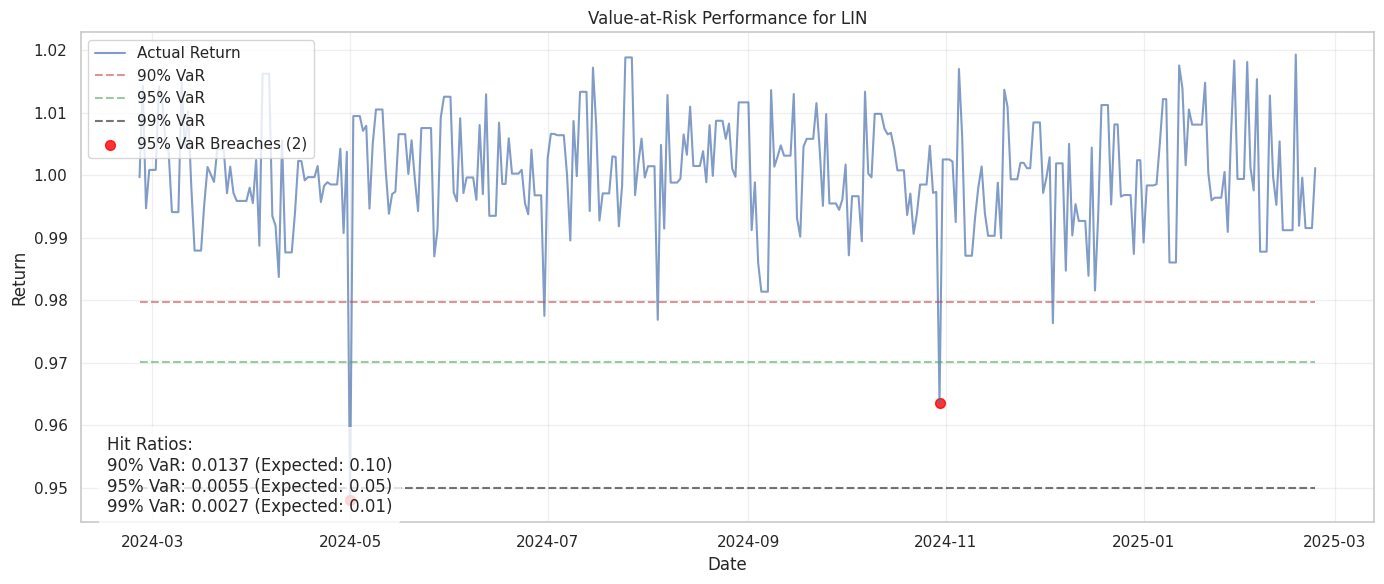

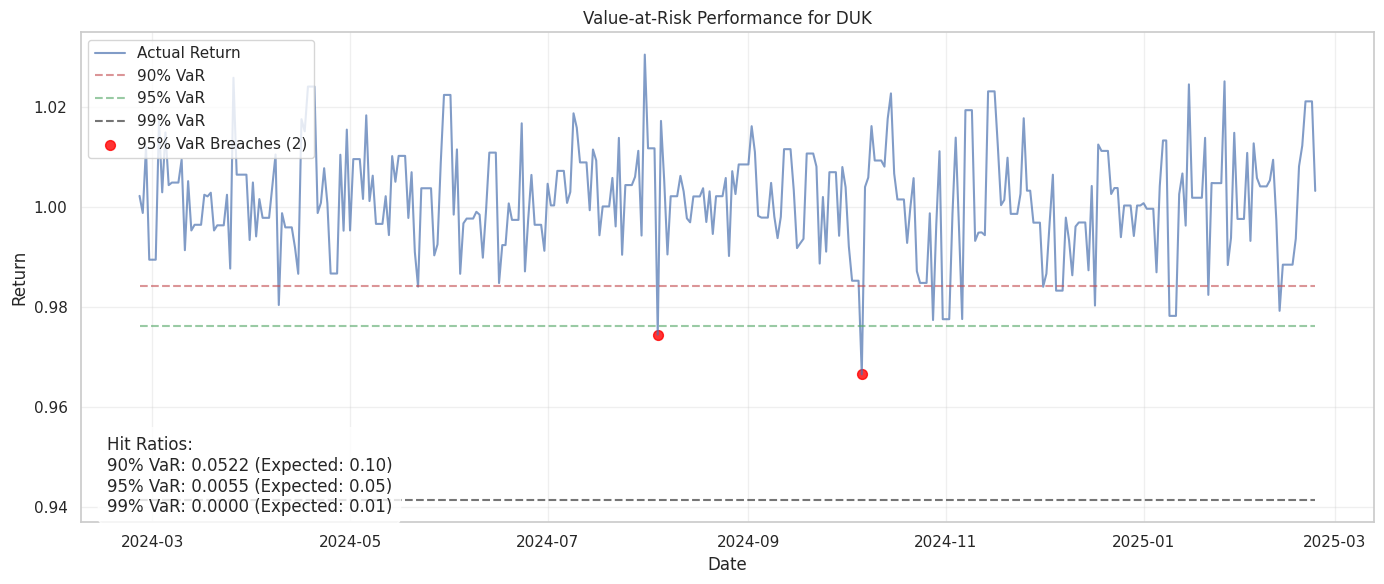

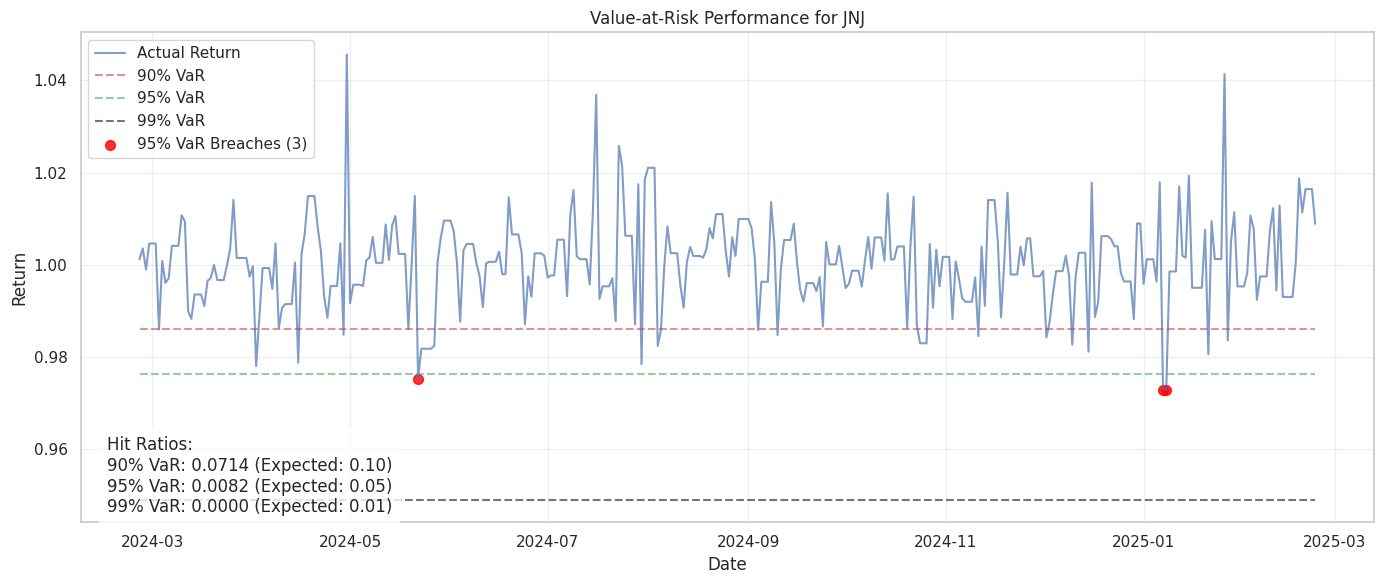

In [8]:
# Select a few representative tickers for detailed analysis
# Choose top 3, middle 3, and bottom 3 based on MSE
top_tickers = ticker_metrics.head(3).index.tolist()
mid_idx = len(ticker_metrics) // 2
mid_tickers = ticker_metrics.iloc[mid_idx-1:mid_idx+2].index.tolist()
bottom_tickers = ticker_metrics.tail(3).index.tolist()

selected_tickers = top_tickers + mid_tickers + bottom_tickers
print(f"Selected tickers for detailed analysis: {selected_tickers}")

# Create a function to plot actual returns vs VaR thresholds for a specific ticker
def plot_var_performance(ticker, backtest_df):
    ticker_data = backtest_df[backtest_df['ticker'] == ticker].sort_values('date')
    
    plt.figure(figsize=(14, 6))
    
    # Plot actual returns
    plt.plot(ticker_data['date'], ticker_data['actual_return'], 'b-', label='Actual Return', alpha=0.7)
    
    # Plot VaR thresholds
    plt.plot(ticker_data['date'], ticker_data['var_10'], 'r--', label='90% VaR', alpha=0.6)
    plt.plot(ticker_data['date'], ticker_data['var_5'], 'g--', label='95% VaR', alpha=0.6)
    plt.plot(ticker_data['date'], ticker_data['var_1'], 'k--', label='99% VaR', alpha=0.6)
    
    # Highlight breaches of the 95% VaR
    breaches = ticker_data[ticker_data['actual_return'] <= ticker_data['var_5']]
    plt.scatter(breaches['date'], breaches['actual_return'], color='red', marker='o', s=50, 
                label=f'95% VaR Breaches ({len(breaches)})', alpha=0.8)
    
    # Add formatting
    plt.title(f'Value-at-Risk Performance for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    hit_ratio_90 = ticker_data['hit_10'].mean()
    hit_ratio_95 = ticker_data['hit_5'].mean()
    hit_ratio_99 = ticker_data['hit_1'].mean()
    
    # Add text with hit ratios
    text_str = f"Hit Ratios:\n90% VaR: {hit_ratio_90:.4f} (Expected: 0.10)\n95% VaR: {hit_ratio_95:.4f} (Expected: 0.05)\n99% VaR: {hit_ratio_99:.4f} (Expected: 0.01)"
    plt.annotate(text_str, xy=(0.02, 0.02), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))
    
    plt.tight_layout()
    return plt

# Plot VaR performance for the first 3 selected tickers
for ticker in selected_tickers[:3]:
    plot_var_performance(ticker, backtest_df)
    plt.show()

#### Ticker-Level Performance 

In [9]:
# Create a comprehensive dashboard for evaluating ticker-level performance
# Combine MSE, correlation, and VaR performance into a single DataFrame

# Merge ticker metrics with VaR hit ratios
dashboard_df = ticker_metrics.join(var_hit_ratios)

# Calculate overall performance score (lower is better)
# Normalize each metric to 0-1 range and combine
dashboard_df['mse_normalized'] = (dashboard_df['mse_mean'] - dashboard_df['mse_mean'].min()) / (dashboard_df['mse_mean'].max() - dashboard_df['mse_mean'].min())
dashboard_df['var_normalized'] = (dashboard_df['Average_Error'] - dashboard_df['Average_Error'].min()) / (dashboard_df['Average_Error'].max() - dashboard_df['Average_Error'].min())

# Calculate overall score (equal weighting)
dashboard_df['overall_score'] = (dashboard_df['mse_normalized'] + 
                                dashboard_df['var_normalized']) / 2

# Sort by overall score
dashboard_df = dashboard_df.sort_values('overall_score')

# Select key columns for display
display_cols = [
    'mse_mean', 'mae_mean',
    'VaR_90%_Hit_Ratio', 'VaR_95%_Hit_Ratio', 'VaR_99%_Hit_Ratio',
    'Average_Error', 'overall_score'
]

# Display the top 10 best performing tickers
print("Top 10 Best Performing Tickers:")
display(dashboard_df[display_cols].head(10))

# Display the 10 worst performing tickers
print("\nBottom 10 Worst Performing Tickers:")
display(dashboard_df[display_cols].tail(10))




Top 10 Best Performing Tickers:


,mse_mean,mae_mean,VaR_90%_Hit_Ratio,VaR_95%_Hit_Ratio,VaR_99%_Hit_Ratio,Average_Error,overall_score
ticker,,,,,,,
EXC,0.000134,0.008750,0.087912,0.035714,0.000000,0.012125,0.036447
CVX,0.000159,0.008937,0.123626,0.054945,0.010989,0.009853,0.037424
MRK,0.000194,0.009408,0.098901,0.035714,0.013736,0.006374,0.038219
PEP,0.000149,0.009211,0.079670,0.035714,0.002747,0.013956,0.045929
VZ,0.000144,0.008840,0.079670,0.024725,0.005495,0.016703,0.051952
AMT,0.000231,0.010997,0.085165,0.046703,0.002747,0.008462,0.054647
SO,0.000123,0.008506,0.076923,0.016484,0.000000,0.022198,0.061049
UPS,0.000274,0.010444,0.112637,0.054945,0.008242,0.006447,0.061691
BKNG,0.000268,0.011306,0.107143,0.063187,0.010989,0.007106,0.061692



Bottom 10 Worst Performing Tickers:


,mse_mean,mae_mean,VaR_90%_Hit_Ratio,VaR_95%_Hit_Ratio,VaR_99%_Hit_Ratio,Average_Error,overall_score
ticker,,,,,,,
ADBE,0.000675,0.014990,0.112637,0.063187,0.021978,0.012601,0.195363
TGT,0.000572,0.016326,0.046703,0.019231,0.005495,0.029524,0.212263
NKE,0.000640,0.013427,0.131868,0.079670,0.027473,0.026337,0.223108
UNH,0.000714,0.023024,0.038462,0.030220,0.010989,0.027436,0.247755
MMM,0.000684,0.013501,0.024725,0.000000,0.000000,0.045092,0.287827
TXN,0.000384,0.014506,0.239011,0.134615,0.021978,0.078535,0.292777
CVS,0.000603,0.016291,0.239011,0.148352,0.027473,0.084945,0.374470
NVDA,0.001078,0.025130,0.291209,0.178571,0.046703,0.118828,0.606306
WBA,0.001804,0.025377,0.208791,0.167582,0.035714,0.084029,0.721547


#### Case Study: Detailed Analysis of Top Performer

Detailed analysis for best performing ticker: EXC


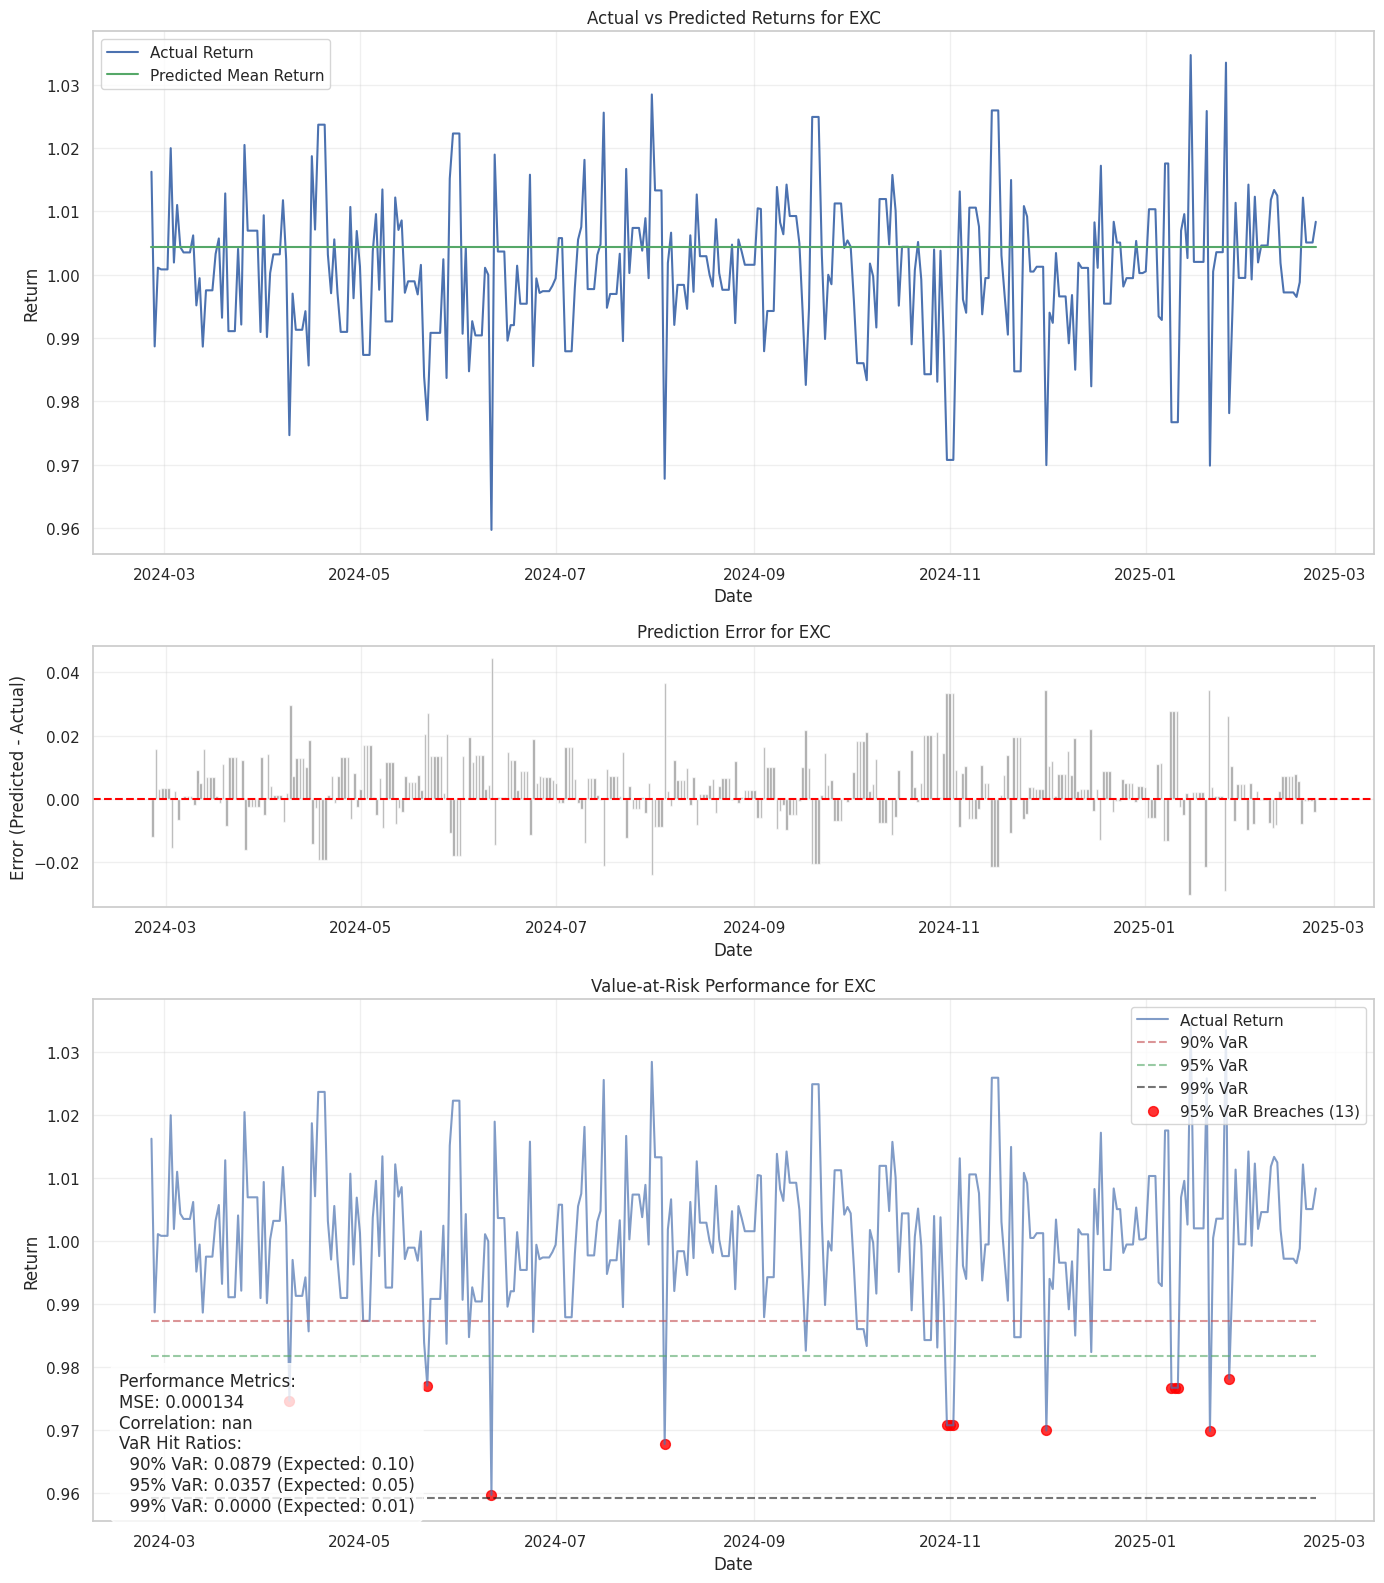

,EXC
Mean Actual Return,1.000793e+00
Mean Predicted Return,1.004325e+00
Std Dev Actual Return,1.102687e-02
Std Dev Predicted Return,0.000000e+00
Max Actual Return,1.034719e+00
Min Actual Return,9.596796e-01
Max Predicted Return,1.004325e+00
Min Predicted Return,1.004325e+00
Correlation,NaN
MSE,1.337357e-04


In [10]:
# Select the best performing ticker for detailed analysis
best_ticker = dashboard_df.index[0]
print(f"Detailed analysis for best performing ticker: {best_ticker}")

# Get data for this ticker
ticker_data = backtest_df[backtest_df['ticker'] == best_ticker].sort_values('date')

# Create a comprehensive visualization for this ticker
fig, axes = plt.subplots(3, 1, figsize=(14, 16), gridspec_kw={'height_ratios': [2, 1, 2]})

# Plot 1: Actual vs Predicted Returns
ax1 = axes[0]
ax1.plot(ticker_data['date'], ticker_data['actual_return'], 'b-', label='Actual Return')
ax1.plot(ticker_data['date'], ticker_data['predicted_mean'], 'g-', label='Predicted Mean Return')
ax1.set_title(f'Actual vs Predicted Returns for {best_ticker}')
ax1.set_xlabel('Date')
ax1.set_ylabel('Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Calculate cumulative returns for this ticker
ticker_data['cum_actual'] = (1 + ticker_data['actual_return']).cumprod() - 1
ticker_data['cum_predicted'] = (1 + ticker_data['predicted_mean']).cumprod() - 1

# Plot 2: Error (Predicted - Actual)
ax2 = axes[1]
error = ticker_data['predicted_mean'] - ticker_data['actual_return']
ax2.bar(ticker_data['date'], error, color='gray', alpha=0.7)
ax2.axhline(y=0, color='red', linestyle='--')
ax2.set_title(f'Prediction Error for {best_ticker}')
ax2.set_xlabel('Date')
ax2.set_ylabel('Error (Predicted - Actual)')
ax2.grid(True, alpha=0.3)

# Plot 3: Value at Risk Performance
ax3 = axes[2]
ax3.plot(ticker_data['date'], ticker_data['actual_return'], 'b-', label='Actual Return', alpha=0.7)
ax3.plot(ticker_data['date'], ticker_data['var_10'], 'r--', label='90% VaR', alpha=0.6)
ax3.plot(ticker_data['date'], ticker_data['var_5'], 'g--', label='95% VaR', alpha=0.6)
ax3.plot(ticker_data['date'], ticker_data['var_1'], 'k--', label='99% VaR', alpha=0.6)

# Highlight breaches
breaches_90 = ticker_data[ticker_data['actual_return'] <= ticker_data['var_10']]
breaches_95 = ticker_data[ticker_data['actual_return'] <= ticker_data['var_5']]
breaches_99 = ticker_data[ticker_data['actual_return'] <= ticker_data['var_1']]

ax3.scatter(breaches_95['date'], breaches_95['actual_return'], color='red', marker='o', s=50, 
           label=f'95% VaR Breaches ({len(breaches_95)})', alpha=0.8)

ax3.set_title(f'Value-at-Risk Performance for {best_ticker}')
ax3.set_xlabel('Date')
ax3.set_ylabel('Return')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# Add summary text
hit_ratio_90 = ticker_data['hit_10'].mean()
hit_ratio_95 = ticker_data['hit_5'].mean()
hit_ratio_99 = ticker_data['hit_1'].mean()
corr = ticker_data[['actual_return', 'predicted_mean']].corr().iloc[0, 1]
mse = ticker_data['mse'].mean()

text_str = (f"Performance Metrics:\n"
            f"MSE: {mse:.6f}\n"
            f"Correlation: {corr:.4f}\n"
            f"VaR Hit Ratios:\n"
            f"  90% VaR: {hit_ratio_90:.4f} (Expected: 0.10)\n"
            f"  95% VaR: {hit_ratio_95:.4f} (Expected: 0.05)\n"
            f"  99% VaR: {hit_ratio_99:.4f} (Expected: 0.01)")

ax3.annotate(text_str, xy=(0.02, 0.02), xycoords='axes fraction', 
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

plt.tight_layout()
plt.show()

# Calculate and display additional statistics for this ticker
stats = {
    'Mean Actual Return': ticker_data['actual_return'].mean(),
    'Mean Predicted Return': ticker_data['predicted_mean'].mean(),
    'Std Dev Actual Return': ticker_data['actual_return'].std(),
    'Std Dev Predicted Return': ticker_data['predicted_mean'].std(),
    'Max Actual Return': ticker_data['actual_return'].max(),
    'Min Actual Return': ticker_data['actual_return'].min(),
    'Max Predicted Return': ticker_data['predicted_mean'].max(),
    'Min Predicted Return': ticker_data['predicted_mean'].min(),
    'Correlation': corr,
    'MSE': mse,
    'MAE': ticker_data['mae'].mean(),
    'Final Cumulative Actual Return': ticker_data['cum_actual'].iloc[-1],
    'Final Cumulative Predicted Return': ticker_data['cum_predicted'].iloc[-1]
}

# Display statistics
pd.DataFrame([stats], index=[best_ticker]).T

#### Overall Model Assessment

In [11]:
# Calculate overall model metrics
overall_metrics = {
    'Mean MSE': dashboard_df['mse_mean'].mean(),
    'Mean MAE': dashboard_df['mae_mean'].mean(),
    'Mean 90% VaR Hit Ratio': dashboard_df['VaR_90%_Hit_Ratio'].mean(),
    'Mean 95% VaR Hit Ratio': dashboard_df['VaR_95%_Hit_Ratio'].mean(),
    'Mean 99% VaR Hit Ratio': dashboard_df['VaR_99%_Hit_Ratio'].mean(),
}

# Display overall metrics
display(pd.DataFrame([overall_metrics], index=['Overall Model Performance']).T)




# Summary conclusion
print("DeepAR Model Performance Summary")
print("--------------------------------")
print(f"Average MSE across all tickers: {overall_metrics['Mean MSE']:.6f}")
print(f"Average 95% VaR hit ratio: {overall_metrics['Mean 95% VaR Hit Ratio']:.4f} (Target: 0.05)")
print(f"Average 99% VaR hit ratio: {overall_metrics['Mean 99% VaR Hit Ratio']:.4f} (Target: 0.01)")


,Overall Model Performance
Mean MSE,0.000325
Mean MAE,0.012128
Mean 90% VaR Hit Ratio,0.081298
Mean 95% VaR Hit Ratio,0.039649
Mean 99% VaR Hit Ratio,0.007428


DeepAR Model Performance Summary
--------------------------------
Average MSE across all tickers: 0.000325
Average 95% VaR hit ratio: 0.0396 (Target: 0.05)
Average 99% VaR hit ratio: 0.0074 (Target: 0.01)
